<a href="https://colab.research.google.com/github/rushiai/pilot-projects/blob/main/10_6_emotion_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

     |████████████████████████████████| 37.7MB 1.4MB/s 


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Raw Webcam Feed', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# cap.release()
# cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
        
        # Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
%%writefile app.py
import cv2
import streamlit as st
import face_recognition
import pandas as pd
import numpy as np

# CONSTANTS
WEBCAMNUM = 2 # from videocapture_index_check.py
PATH_DATA = 'data/DB.csv'
COLOR_DARK = (0, 0, 153)
COLOR_WHITE = (255, 255, 255)
COLS_INFO = ['name', 'description']
COLS_ENCODE = [f'v{i}' for i in range(128)]

st.title("Webcam Face Recognition")
FRAME_WINDOW = st.image([])

@st.cache
def load_known_data():
    DB = pd.read_csv(PATH_DATA)
    return (
        DB['name'].values, 
        DB[COLS_ENCODE].values
        )

def capture_face(video_capture):
    # got 3 frames to auto adjust webcam light
    for i in range(3):
        video_capture.read()

    while(True):
        ret, frame = video_capture.read()
        FRAME_WINDOW.image(frame[:, :, ::-1])
        # face detection
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = small_frame[:, :, ::-1]
        face_locations = face_recognition.face_locations(rgb_small_frame)
        if len(face_locations) > 0:
            video_capture.release()
            return frame

def face_distance_to_conf(face_distance, face_match_threshold=0.6):
    if face_distance > face_match_threshold:
        range = (1.0 - face_match_threshold)
        linear_val = (1.0 - face_distance) / (range * 2.0)
        return linear_val
    else:
        range = face_match_threshold
        linear_val = 1.0 - (face_distance / (range * 2.0))
        return linear_val + ((1.0 - linear_val) * np.power((linear_val - 0.5) * 2, 0.2))

def recognize_frame(frame):
    # convert COLOR_BGR2RGB
    rgb_frame = frame[:, :, ::-1]
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # Draw a box around the face
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)

        best_match_index = np.argmin(face_distances)
        name = known_face_names[best_match_index]
        similarity = face_distance_to_conf(face_distances[best_match_index], 0.5)
        cv2.rectangle(frame, (left, top), (right, bottom), COLOR_DARK, 2)
        return name, similarity, frame[:, :, ::-1]

if __name__ == "__main__":
    while(True):
        known_face_names, known_face_encodings = load_known_data()
        video_capture = cv2.VideoCapture(WEBCAMNUM)
        frame = capture_face(video_capture)
        name, similarity, frame = recognize_frame(frame)
        FRAME_WINDOW.image(frame)
        if similarity > 0.75:
            label = f"**{name}**: *{similarity:.2%} likely*"
            st.markdown(label)
            break
    # press to restart the scripts
    st.button('contunue......')

Overwriting app.py


In [ ]:
%%writefile app.py
"""
Check which inputs are a valid camera.
https://github.com/robmarkcole/mqtt-camera-streamer/blob/master/scripts/check-opencv-cameras.py
"""
import streamlit as st

import cv2

def check_webcam():
    webcam_dict = dict()
    for i in range(0, 10):
        cap = cv2.VideoCapture(i)
        is_camera = cap.isOpened()
        if is_camera:
            webcam_dict[f"index[{i}]"] = "VALID"
            cap.release()
        else:
            webcam_dict[f"index[{i}]"] = None
    return webcam_dict

if __name__ == "__main__":
    st.title('WebCam index validation check')
    webcam_dict = check_webcam()
    st.write(webcam_dict)

Overwriting app.py


In [ ]:
pip install colab-everything

In [ ]:
%%writefile app.py
st.write("""
         # Handwritten Recognition
         """
         )
st.write("This is a simple Handwritten Recognition web app to predict your handwritten text")
file = st.file_uploader("Please upload an image file", type=["jpg", "png"])
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    img_array = np.array(image)
    cv2.imwrite('out.jpg', cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))
    prediction = model_predict('out.jpg', model)
    st.write(prediction)

Overwriting app.py


In [ ]:
from colab_everything import ColabStreamlit
ColabStreamlit('/content/app.py')

Web App can be accessed on: http://ac7baa297feb.ngrok.io


In [1]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!pip install mediapipe

     |████████████████████████████████| 37.7MB 122kB/s 


In [3]:
a = []

In [4]:
!wget https://github.com/rushiai/data_csv/blob/main/small_emotion.mp4?raw=true

--2021-06-10 06:20:48--  https://github.com/rushiai/data_csv/blob/main/small_emotion.mp4?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rushiai/data_csv/raw/main/small_emotion.mp4 [following]
--2021-06-10 06:20:49--  https://github.com/rushiai/data_csv/raw/main/small_emotion.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rushiai/data_csv/main/small_emotion.mp4 [following]
--2021-06-10 06:20:49--  https://raw.githubusercontent.com/rushiai/data_csv/main/small_emotion.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 20

In [5]:
count = 0

In [6]:
import cv2
import mediapipe as mp
import time


class FaceMeshDetector():

    def __init__(self, staticMode=False, maxFaces=2, minDetectionCon=0.5, minTrackCon=0.5):

        self.staticMode = staticMode
        self.maxFaces = maxFaces
        self.minDetectionCon = minDetectionCon
        self.minTrackCon = minTrackCon

        self.mpDraw = mp.solutions.drawing_utils
        self.mpFaceMesh = mp.solutions.face_mesh
        self.faceMesh = self.mpFaceMesh.FaceMesh(self.staticMode, self.maxFaces,
                                                 self.minDetectionCon, self.minTrackCon)
        self.drawSpec = self.mpDraw.DrawingSpec(thickness=1, circle_radius=2)

    def findFaceMesh(self, img, draw=False):
        self.imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.faceMesh.process(self.imgRGB)
        faces = []
        if self.results.multi_face_landmarks:
            for faceLms in self.results.multi_face_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(img, faceLms, self.mpFaceMesh.FACE_CONNECTIONS,
                                           self.drawSpec, self.drawSpec)
                face = []
                for id,lm in enumerate(faceLms.landmark):
                    #print(lm)
                    ih, iw, ic = img.shape
                    x,y = int(lm.x*iw), int(lm.y*ih)
                    #cv2.putText(img, str(id), (x, y), cv2.FONT_HERSHEY_PLAIN,
                     #           0.7, (0, 255, 0), 1)

                    #print(id,x,y)
                    face.append([x,y])
                faces.append(face)
        return img, faces


def main(a,count):
    cap = cv2.VideoCapture("./small_emotion.mp4?raw=true")
    pTime = 0
    detector = FaceMeshDetector(maxFaces=2)
    while True:
        success, img = cap.read()
        img, faces = detector.findFaceMesh(img)
        if len(faces)!= 0:
            print(count)
#             print(faces[0])
#             a = np.append(a,faces[0])
            a.append(faces[0])
#             time.sleep(1)
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        count += 1
        # cv2.putText(img, f'FPS: {int(fps)}', (20, 70), cv2.FONT_HERSHEY_PLAIN,
        #             3, (0, 255, 0), 3)
        # cv2.imshow("Image", img)
        cv2.waitKey(1)



if __name__ == "__main__":
    main(a,count)

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
815
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853


error: ignored

In [61]:
np.array(a).shape

(744, 468, 2)

In [62]:
df = pd.DataFrame(a)

In [63]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467
0,"[312, 179]","[314, 166]","[313, 168]","[310, 146]","[314, 161]","[315, 153]","[315, 133]","[277, 127]","[316, 117]","[316, 110]","[317, 84]","[312, 181]","[311, 183]","[311, 183]","[312, 184]","[311, 186]","[311, 189]","[311, 191]","[311, 195]","[314, 168]","[308, 166]","[259, 99]","[293, 132]","[288, 132]","[283, 131]","[276, 127]","[297, 131]","[285, 117]","[291, 117]","[280, 117]","[276, 119]","[272, 130]","[292, 200]","[275, 125]","[257, 122]","[266, 125]","[287, 153]","[305, 178]","[306, 182]","[298, 178]",...,"[320, 205]","[329, 154]","[341, 191]","[334, 196]","[342, 182]","[359, 169]","[348, 182]","[360, 171]","[342, 174]","[326, 146]","[325, 164]","[328, 164]","[324, 161]","[331, 120]","[340, 117]","[347, 117]","[353, 118]","[356, 121]","[357, 129]","[367, 139]","[353, 137]","[347, 139]","[341, 138]","[335, 137]","[330, 135]","[327, 134]","[366, 137]","[328, 165]","[323, 149]","[322, 165]","[319, 167]","[322, 165]","[327, 166]","[318, 167]","[317, 168]","[328, 129]","[325, 131]","[323, 132]","[352, 128]","[355, 125]"
1,"[310, 177]","[312, 165]","[311, 167]","[309, 145]","[313, 160]","[313, 152]","[314, 131]","[277, 125]","[315, 116]","[315, 109]","[317, 82]","[310, 179]","[309, 181]","[309, 181]","[309, 185]","[309, 187]","[308, 190]","[308, 192]","[308, 195]","[312, 167]","[306, 165]","[259, 98]","[292, 129]","[287, 130]","[282, 129]","[275, 126]","[296, 128]","[284, 116]","[290, 116]","[278, 116]","[275, 118]","[270, 128]","[289, 198]","[274, 123]","[255, 120]","[264, 123]","[286, 152]","[303, 176]","[303, 180]","[296, 177]",...,"[316, 203]","[328, 151]","[339, 188]","[332, 193]","[340, 179]","[358, 164]","[346, 178]","[359, 166]","[339, 171]","[325, 144]","[324, 162]","[327, 162]","[322, 160]","[330, 118]","[339, 115]","[346, 115]","[352, 116]","[355, 118]","[356, 125]","[367, 135]","[352, 133]","[346, 135]","[340, 135]","[334, 134]","[329, 132]","[326, 131]","[366, 131]","[327, 162]","[321, 147]","[321, 163]","[318, 165]","[321, 164]","[326, 164]","[317, 166]","[316, 166]","[327, 127]","[324, 128]","[322, 130]","[351, 124]","[354, 122]"
2,"[313, 178]","[314, 166]","[314, 168]","[310, 147]","[314, 161]","[314, 153]","[314, 133]","[278, 127]","[315, 117]","[315, 109]","[316, 83]","[313, 180]","[313, 182]","[313, 182]","[313, 183]","[313, 185]","[313, 188]","[313, 190]","[312, 193]","[314, 168]","[309, 166]","[260, 100]","[293, 132]","[288, 132]","[283, 132]","[276, 128]","[297, 131]","[285, 118]","[290, 118]","[279, 118]","[276, 120]","[272, 131]","[295, 198]","[275, 126]","[257, 123]","[266, 126]","[288, 154]","[307, 177]","[307, 182]","[300, 178]",...,"[321, 202]","[329, 152]","[343, 187]","[336, 192]","[343, 178]","[361, 164]","[350, 178]","[363, 166]","[343, 171]","[326, 145]","[326, 163]","[329, 162]","[324, 160]","[330, 119]","[339, 116]","[346, 115]","[352, 116]","[356, 118]","[358, 126]","[370, 134]","[353, 134]","[348, 136]","[341, 136]","[335, 135]","[330, 134]","[327, 132]","[369, 131]","[328, 163]","[323, 148]","[322, 164]","[319, 166]","[322, 164]","[327, 164]","[318, 167]","[318, 167]","[327, 128]","[325, 130]","[323, 131]","[352, 126]","[355, 122]"
3,"[313, 175]","[313, 163]","[313, 165]","[309, 144]","[313, 158]","[313, 150]","[314, 130]","[278, 124]","[314, 116]","[314, 109]","[315, 81]","[312, 177]","[312, 178]","[312, 178]","[312, 180]","[312, 182]","[312, 184]","[312, 186]","[312, 190]","[313, 165]","[308, 163]","[261, 98]","[293, 129]","[288, 129]","[283, 129]","[276, 125]","[297, 128]","[285, 115]","[291, 116]","[279, 116]","[276, 118]","[272, 128]","[294, 195]","[276, 122]","[258, 121]","[266, 123]","[288, 151]","[306, 174]","[307, 178]","[300, 174]",...,"[321, 199]","[328, 150]","[343, 184]","[336, 190]","[344, 176]","[3

In [64]:
df.iloc[0][1]

[314, 166]

100%|██████████| 468/468 [00:00<00:00, 6514.43it/s]


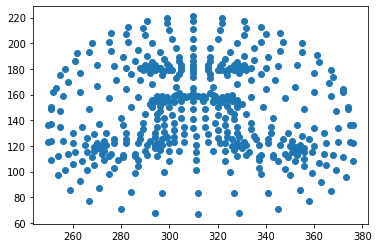

In [65]:
row = 660
x = []
y = []
for i in tqdm(range(0,len(df.iloc[row]))):
    x.append(df.iloc[row][i][0])
    y.append(df.iloc[row][i][1])
plt.scatter(x, y)
plt.show()

In [66]:
df.shape

(744, 468)

In [67]:
for i in tqdm(range(0,468)):
    df[i]= df[i].apply(str)

100%|██████████| 468/468 [00:00<00:00, 953.94it/s]


In [71]:
type(df.iloc[0][0])

str

In [72]:
df[2].value_counts().index

Index(['[282, 219]', '[311, 159]', '[311, 160]', '[312, 162]', '[310, 160]',
       '[284, 220]', '[308, 161]', '[313, 162]', '[309, 161]', '[312, 159]',
       ...
       '[284, 222]', '[318, 174]', '[313, 168]', '[289, 181]', '[321, 173]',
       '[296, 199]', '[291, 221]', '[281, 225]', '[294, 202]', '[298, 203]'],
      dtype='object', length=223)

In [ ]:
set(df[2].value_counts().index)

In [77]:
a = set()

In [78]:
type(a)

set

In [82]:
for i in df[2].value_counts().index:
    a.add(i)

In [83]:
for col in tqdm(range(0,468)):
    for val in df[col].value_counts().index:
        a.add(val)

100%|██████████| 468/468 [00:00<00:00, 1137.79it/s]


In [87]:
len(a)

25687

In [94]:
char_to_num = {char:num for num,char in enumerate(a)}

In [100]:
dfz = pd.DataFrame()
for col in tqdm(range(0,468)):
    dfz[col] = df[col].map(char_to_num)

100%|██████████| 468/468 [00:19<00:00, 23.64it/s]


In [101]:
dfz

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467
0,12815,5087,5678,9067,23681,1429,871,25273,21759,1164,21970,10529,20759,20759,23552,19135,13175,11775,9863,14987,16280,8844,6544,19519,15792,24798,1971,10736,4560,24043,13953,25240,4554,19224,24459,1117,8853,8934,503,887,...,20608,25267,1560,869,17852,6239,109,11583,21318,20338,5561,11505,15086,22301,2322,19456,4814,19533,23924,15472,14138,16834,2393,1566,24660,5638,7262,24650,22767,11093,14676,11093,13165,23240,18331,13074,22718,1099,2070,3368
1,16037,15530,10668,18850,25588,8257,20795,11418,25684,12560,16728,20928,23265,23265,6421,22317,5674,17190,2587,20924,4985,6621,11416,15310,4602,4085,24724,3619,21991,15568,23382,17410,18046,10897,21982,3509,24870,25567,17926,13879,...,15369,11310,1489,20346,21210,24855,13050,4798,9441,9915,167,22516,17245,13645,24291,4483,23639,12570,24237,10164,18166,267,21981,23217,24340,8559,2687,22516,7859,10492,10411,2263,17447,4423,8764,17266,20930,17911,12265,22262
2,8913,5087,14987,21327,23681,2858,10852,5444,24244,12560,22888,15504,16725,16725,6468,2276,5547,15399,13067,14987,6176,6744,6544,19519,20558,19569,1971,21096,16619,21737,20063,23869,25226,4085,19437,18464,11865,3754,23572,5626,...,1518,5145,17696,18532,13286,7275,8629,19937,14631,4512,18402,7792,15591,14142,23025,4483,23639,20341,16103,21652,20211,13424,4205,12188,19281,20607,12850,22442,22216,9054,1451,9054,18758,23240,23240,23545,24943,19003,644,2370
3,2150,20860,21027,16412,5099,5631,10213,7380,18140,15605,14402,24694,5384,5384,15188,22942,23552,15729,4526,21027,20185,4307,14763,661,2331,12786,7219,19385,10933,9359,25265,14366,900,2195,19712,10456,10608,10031,22735,3653,...,20991,22376,17469,9908,14745,1313,20673,22543,24915,8555,8272,7644,17355,3349,1891,19247,19068,7298,19732,14893,17815,12598,0,14036,13709,20062,17160,7644,9584,12836,20494,22039,10995,6490,6490,19786,21012,538,6078,1003
4,2150,23111,18559,18202,12681,19736,10213,17043,18140,15605,14402,8544,8913,8913,21806,15504,6468,2276,5547,18559,10552,5089,14763,22714,2331,2088,7219,3619,21991,9359,25265,14366,1865,1679,19585,10456,10608,9342,2588,8837,...,1854,25637,3171,25682,12642,18526,20673,21473,24915,9853,8272,7644,17355,3349,16131,19247,15955,5897,24073,6376,15835,24330,0,14036,13709,20062,22518,7644,9584,9596,20390,8304,17902,3132,3132,19786,16593,538,4861,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,4462,8572,4648,15144,5061,5824,9591,7589,1231,10190,22269,22735,12350,12350,19307,5811,14173,22748,11022,12082,17091,23083,2988,23223,12952,1117,18541,24262,19600,22491,11576,13382,6224,20153,2879,15420,1755,24514,2424,18185,...,12491,8754,292,11945,693,20250,11911,3529,8971,1855,12947,19418,18685,6410,23288,3297,3103,7331,24117,14504,24050,12606,1824,25507,24099,7632,16590,17355,7504,12052,24369,21807,8434,24261,2997,3275,25598,16216,24595,17289
740,5029,7703,20185,15144,24214,1754,9591,7589,1231,10190,22269,14196,18195,7201,23496,14161,3727,17190,13151,21838,17365,23083,2988,16410,12952,1117,12833,24262,19600,11838,11576,13382,6224,20153,2879,14183,1755,1828,6836,8718,...,12032,18771,25268,22894,17469,20250,16839,5193,8971,22243,3422,19418,23740,3888,5665,14532,3103,7331,24117,16590,10940,12606,20370,22720,24099,7632,22943,14393,643,21807,12258,16140,17245,24261,2997,25164,25598,21530,24595,17289
741,5029,7109,20185,15144,24214,1754,9591,784,1231,10190,22269,2588,18195,18195,23496,14161,3727,14560,13151,21838,17365,23083,2988,23223,12952,1117,17994,24262,19600,11838,11576,13382,6224,20153,2879,14183,1755,1828,

In [103]:
len(char_to_num.keys())

25687

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(dfz))

# print(scaler.data_max_)

df_scale = scaler.transform(dfz)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [105]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
kmeans = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans.fit(df_scale)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(df_scale)

[[0.66741159 0.64684814 0.57925418 ... 0.4239441  0.53167743 0.5430015 ]
 [0.5134694  0.50287951 0.48031406 ... 0.53257265 0.49741739 0.52684426]
 [0.43930349 0.45017562 0.46628375 ... 0.52807757 0.54547479 0.52401942]
 ...
 [0.70609707 0.54861596 0.35866832 ... 0.56922897 0.71632716 0.49659555]
 [0.53187959 0.51983004 0.34837721 ... 0.35986246 0.7255702  0.38376351]
 [0.57432182 0.30580915 0.67472213 ... 0.58159237 0.45492624 0.62782085]]


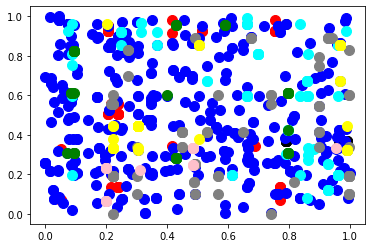

In [107]:
plt.scatter(df_scale[y_km ==0,0], df_scale[y_km == 0,1], s=100, c='red')
plt.scatter(df_scale[y_km ==1,0], df_scale[y_km == 1,1], s=100, c='black')
plt.scatter(df_scale[y_km ==2,0], df_scale[y_km == 2,1], s=100, c='blue')
plt.scatter(df_scale[y_km ==3,0], df_scale[y_km == 3,1], s=100, c='cyan')
plt.scatter(df_scale[y_km ==4,0], df_scale[y_km == 4,1], s=100, c='gray')
plt.scatter(df_scale[y_km ==5,0], df_scale[y_km == 5,1], s=100, c='pink')
plt.scatter(df_scale[y_km ==6,0], df_scale[y_km == 6,1], s=100, c='green')
plt.scatter(df_scale[y_km ==7,0], df_scale[y_km == 7,1], s=100, c='yellow')
# plt.scatter(df_scale[y_km ==2,0], df_scale[y_km == 2,1], s=100, c='magenta')
# plt.scatter(df_scale[y_km ==3,0], df_scale[y_km == 3,1], s=100, c='cyan')

Text(0, 0.5, 'Second Principal Component')

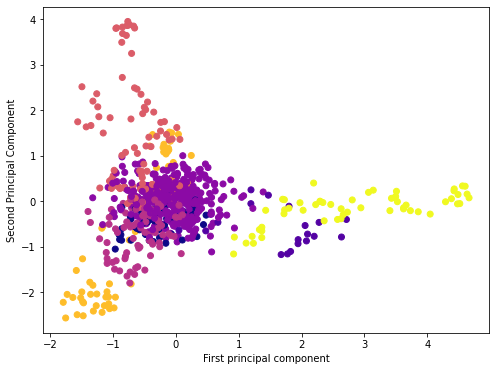

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(df_scale)
x_pca = pca.transform(df_scale)
x_pca.shape
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_km,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_scale, y_km, test_size=0.25, random_state=42)

In [112]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
target_names = [str(i) for i in range(0,8)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00         6
           2       0.57      1.00      0.73       101
           3       0.00      0.00      0.00        13
           4       1.00      0.11      0.20        18
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        16
           7       1.00      0.78      0.88         9

    accuracy                           0.59       186
   macro avg       0.32      0.24      0.23       186
weighted avg       0.46      0.59      0.46       186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
import xgboost as xgb
my_model = xgb.XGBClassifier()
my_model.fit(X_train, y_train)
   
# Predicting the Test set results
y_pred = my_model.predict(X_test)
from sklearn.metrics import classification_report
target_names = [str(i) for i in range(0,8)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       1.00      0.83      0.91         6
           2       0.90      1.00      0.95       101
           3       0.92      0.92      0.92        13
           4       1.00      0.94      0.97        18
           5       1.00      1.00      1.00         4
           6       1.00      0.75      0.86        16
           7       1.00      1.00      1.00         9

    accuracy                           0.94       186
   macro avg       0.98      0.90      0.93       186
weighted avg       0.94      0.94      0.93       186



In [128]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
target_names = [str(i) for i in range(0,8)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      1.00      1.00         6
           2       0.96      0.99      0.98       101
           3       0.85      0.85      0.85        13
           4       1.00      0.94      0.97        18
           5       1.00      1.00      1.00         4
           6       1.00      0.88      0.93        16
           7       0.90      1.00      0.95         9

    accuracy                           0.96       186
   macro avg       0.96      0.95      0.96       186
weighted avg       0.96      0.96      0.96       186



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [129]:
clf.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [130]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
target_names = [str(i) for i in range(0,8)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       1.00      1.00      1.00         6
           2       0.99      0.89      0.94       101
           3       0.81      1.00      0.90        13
           4       0.86      1.00      0.92        18
           5       1.00      1.00      1.00         4
           6       0.88      0.88      0.88        16
           7       0.82      1.00      0.90         9

    accuracy                           0.92       186
   macro avg       0.90      0.96      0.93       186
weighted avg       0.93      0.92      0.93       186

